# 1. Import & Setting

### 1-1) import

In [207]:
import os
import datetime
import numpy as np
import pandas as pd
from tqdm import tqdm
from pyarrow import csv
from matplotlib import pyplot as plt
from matplotlib import font_manager, rc

import bus

### 1-2) import

In [206]:
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

# 2. Def

### 2-1) 데이터 전처리
* 날짜 데이터 int -> datetime 변환

In [3]:
def data_preprocessing(usage_df):
    # datetime64로 형 변환 # M[base_date] = pd.to_datetime(M[base_date], format='%Y%m%d')
    datetime_cols = ["geton_datetime", "getoff_datetime"]    
    for col in tqdm(datetime_cols):
        usage_df[col] = pd.to_datetime(usage_df[col], format='%Y%m%d%H%M%S')
    return usage_df

### 2-2) 유저별 이용데이터 분석

In [248]:
def create_user_df(usage_df):    # 유저 목록 생성
    return usage_df[["user_id"]].drop_duplicates()

def analyze_usage_date(usage_df, user_df):    # 이용기간 및 이용 날짜 분석
    grouped = usage_df[["user_id", "base_date"]].drop_duplicates().groupby(by=["user_id"], as_index=False)
    first_date_df = grouped.min().rename(columns = {"base_date" : "first_date"})
    last_date_df = grouped.max().rename(columns = {"base_date" : "last_date"})
    use_days_df= grouped.count().rename(columns = {"base_date" : "use_days"})
    user_df = pd.merge(user_df, first_date_df, on="user_id")
    user_df = pd.merge(user_df, last_date_df, on="user_id")
    user_df = pd.merge(user_df, use_days_df, on="user_id")
    user_df['first_date'] = user_df['first_date'].apply(lambda x : datetime.datetime.strptime(str(x), "%Y%m%d").date()) 
    user_df['last_date'] = user_df['last_date'].apply(lambda x : datetime.datetime.strptime(str(x), "%Y%m%d").date())
    user_df["period"] = user_df["last_date"] - user_df["first_date"]
    user_df["period"] = user_df["period"].apply(lambda x : int(str(x).split(" ")[0])+1)
    return user_df

def analyze_usage_num(usage_df, user_df):    # 버스 이용량 분석
    grouped = usage_df[["user_id", "base_date"]].groupby(by=["user_id"], as_index=False)
    count_df = grouped.count().rename(columns = {"base_date" : "usage"})
    user_df = pd.merge(user_df, count_df, on="user_id")
    return user_df

def analyze_start_end(usage_df, user_df):    # 첫 승차 정류장과 마지막 하차 정류장 분석
    grouped = usage_df.sort_values(['geton_datetime']).groupby(by=["user_id"], as_index=False)
    first = grouped.first()
    last = grouped.last()
    first['first_station'] = first['geton_stataion_name'].apply(lambda x : "airport" if str(x).find("공항") != -1 else "harbor" if (
                                                             bool(str(x).find("여객터미널") != -1)| 
                                                             bool(str(x).find("여객선")     != -1)|
                                                             bool(str(x).find("제6부두")    != -1)|
                                                             bool(str(x).find("제4부두")    != -1)|
                                                             bool(str(x).find("임항로")     != -1)|
                                                             bool(str(x).find("제주해양경찰서") != -1)) else "other")
    last['last_station'] = last['getoff_station_name'].apply(lambda x : "airport" if str(x).find("공항") != -1 else "harbor" if (
                                                             bool(str(x).find("여객터미널") != -1)| 
                                                             bool(str(x).find("여객선")     != -1)|
                                                             bool(str(x).find("제6부두")    != -1)|
                                                             bool(str(x).find("제4부두")    != -1)|
                                                             bool(str(x).find("임항로")     != -1)|
                                                             bool(str(x).find("제주해양경찰서")!= -1))  else "other")
    first2 = first[["user_id", "first_station"]]
    last2 = last[["user_id", "last_station"]]
    flag_df = pd.merge(first2, last2, on = "user_id")
    flag_df["both"] = (flag_df["first_station"]!='other') & (flag_df["last_station"]!='other')
    flag_df["first"] = (flag_df["first_station"]!='other') & (flag_df["last_station"]=='other')
    flag_df["last"] = (flag_df["first_station"]=='other') & (flag_df["last_station"]!='other')
    flag_df["neither"] = (flag_df["first_station"]=='other') & (flag_df["last_station"]=='other')
    flag_df = flag_df.reset_index()
    flag_df = flag_df[['user_id', 'first_station', 'last_station', 'both', 'first', 'last', 'neither']]
    user_df = pd.merge(user_df, flag_df)
    return user_df

### 2-3) 관광객 추출1~4

In [275]:
def extract_user1(user_df):
    user_df["tourist"] = (2 <= user_df['period']) & (user_df['period'] <= 14)
    return user_df

def extract_user2(user_df):
    select = user_df.columns
    user_df["goal"] = user_df["period"].apply(lambda x : int(x*1/10))
    user_df["tourist"] = user_df["tourist"] & (user_df["use_days"] >= user_df["goal"])
    return user_df[select]

def extract_user3(user_df):
    user_df["tourist"] = user_df["tourist"] & user_df["both"]
#     user_df["tourist"] = user_df["tourist"] & (user_df["both"] | user_df["first"] | user_df["last"])
    return user_df

def extract_user4(user_df):
    user_df["tourist"] = user_df["tourist"] & (user_df['usage'] >= 10)
    return user_df

# 3. main

### 3-1) - 버스이용데이터 로딩

In [ ]:
start_date = datetime.datetime(2019, 6, 1)
end_date = datetime.datetime(2019, 8, 29)

input_path_list = bus.make_input_path(start_date, end_date)

usage_df = bus.load_total_usage_data(input_path_list)
usage_df = data_preprocessing(usage_df)

### 3-2) - 이용자 추출

In [250]:
user_df = create_user_df(usage_df)
print("유저 목록 생성")
user_df = analyze_usage_date(usage_df, user_df)
print("이용 날짜 분석 완료")
user_df = analyze_usage_num(usage_df, user_df)
print("이용 횟수 분석 완료")
user_df = analyze_start_end(usage_df, user_df)
print("출발, 도작지 분석 완료")

유저 목록 생성
이용 날짜 분석 완료
이용 횟수 분석 완료
출발, 도작지 분석 완료


### 3-3) - 관광객 추출

In [257]:
D = usage_df["user_id"]
print('추출 전 data의 개수', len(D))
print('추출 전 user_id의 개수', len(user_df), '\n')

user_df = extract_user1(user_df)
print('1차 추출 (방문기간 고려) 완료 \nuser_id의 개수:', len(user_df[user_df["tourist"]]), "\n\n")

user_df = extract_user2(user_df)
print('2차 추출 (이용 날짜 수 고려) 완료 \nuser_id의 개수:', len(user_df[user_df["tourist"]]), "\n\n")

user_df = extract_user3(user_df)
print('3차 추출 (시작, 끝 정류장 고려) 완료 \nuser_id의 개수:', len(user_df[user_df["tourist"]]), "\n\n")

# user_df = extract_user4(user_df)
# print('4차 추출 (일정량 이상 이용) 완료 \nuser_id의 개수:', len(user_df[user_df["tourist"]]), "\n\n")

#유의사항: 실제 사용자(관광객) 수는 user_id의 개수보다 크거나 같을 것. (사용자 수는 user_count로 파악할 것.)
user_df.to_csv("user_list.csv", encoding="utf-8", index=False)
print("저장완료")

추출 전 data의 개수 12291789
추출 전 user_id의 개수 726322 

1차 추출 (방문기간 고려) 완료 
user_id의 개수: 201124 




<ipython-input-256-bfaed27fd290>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_df["tourist"] = (2 <= user_df['period']) & (user_df['period'] <= 14)


2차 추출 (이용 날짜 수 고려) 완료 
user_id의 개수: 201124 


3차 추출 (시작, 끝 정류장 고려) 완료 
user_id의 개수: 37442 


저장완료


### 3-4) 유저 데이터 출력

In [254]:
user_df

,user_id,first_date,last_date,use_days,period,usage,first_station,last_station,both,first,last,neither,tourist
0,f6f372cf8c6732eafc2a82b4f9d7a08bb3b493213ea4ef...,2019-06-01,2019-06-09,5,9,14,other,other,False,False,False,True,False
1,3f6cfe2429f6e8d62cddc39222993405789b7b9ea2a592...,2019-06-01,2019-08-28,26,89,59,other,other,False,False,False,True,False
2,107cd874732b48a35df957bf653751154b0234e5573ba5...,2019-06-01,2019-08-28,63,89,249,other,other,False,False,False,True,False
3,27b16001fafd812b1e5c474cbc60455a9286ad27ecf8e5...,2019-06-01,2019-08-28,47,89,83,other,other,False,False,False,True,False
4,89c9a1c6e5915df4c192acc54067ee9a743f44eb559f3b...,2019-06-01,2019-08-28,26,89,35,other,other,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
726317,1c0b23153f52f11215e7d1f4e45dcecfa6d669676c4a9f...,2019-08-28,2019-08-28,1,1,1,other,other,False,False,False,True,False
726318,8235b6d43ba2e06d89fe94fda0dfdb7b4fe678ac58eaf5...,2019-08-28,2019-08-28,1,1,1,other,other,False,False,False,True,False
726319,f6f259fe96fd2e245be452a154c7c43ac747bc0f5d5ad1...,2019-08-29,2019-08-29,1,1,1,other,other,False,False,False,True,False
726320,670048e0bb0ed87661ef4e33fe476d74e4616c137bcdb0...,2019-08-29,2019-08-29,1,1,1,other,other,False,False,False,True,False


# 4. 결과 출력 

### 4-1) 이용자 유형 분석

In [203]:
print("공항에서 시작하는 이용자")
a = user_df[user_df["first_station"] == "airport"]
b = a["last_station"].value_counts()
print("(harbor->airport) {}(명)".format(b[0]))
print("(harbor->harbor)  {}(명)".format(b[1]))
print("(harbor->other)   {}(명)".format(b[2]))

print("\n항만에서 시작하는 이용자")
a = user_df[user_df["first_station"] == "harbor"]
b = a["last_station"].value_counts()
print("(harbor->airport) {}(명)".format(b[0]))
print("(harbor->harbor)  {}(명)".format(b[1]))
print("(harbor->other)   {}(명)".format(b[2]))

공항에서 시작하는 이용자
(harbor->airport) 130647(명)
(harbor->harbor)  46429(명)
(harbor->other)   463(명)

항만에서 시작하는 이용자
(harbor->airport) 3414(명)
(harbor->harbor)  793(명)
(harbor->other)   560(명)


In [271]:
def period_user(plt, user_df):
    data = user_df['period'].value_counts().reset_index().sort_values('index')
    data_x = data['index']
    data_y = data['period']

    plt.bar(data_x, data_y)
    plt.title('도민의 이용 기간 별 이용자 수')
    plt.xlabel('방문기간')
    plt.ylabel('방문자 수')

#### 관관객의 이용기간 별 이용자 수

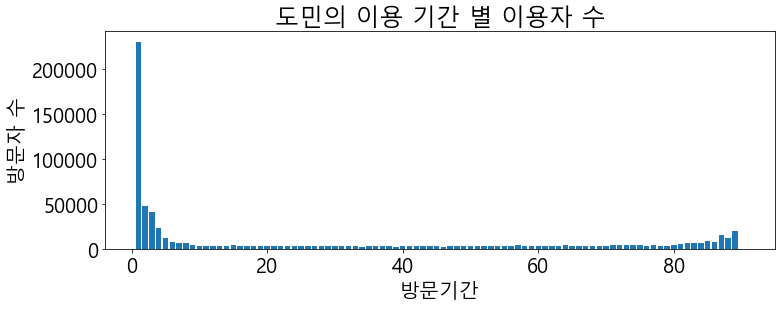

In [272]:
data = user_df[user_df['tourist'] == False]
period_user(plt, data)

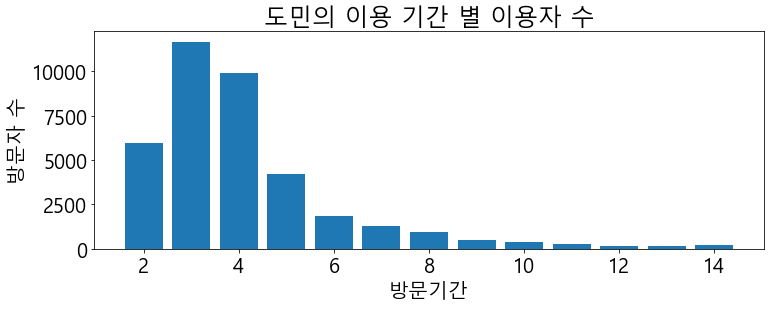

In [273]:
data = user_df[user_df['tourist'] == True]
period_user(plt, data)

In [146]:
user_df

,user_id,first_date,last_date,use_days,period,usage,first_station,last_station,both,first,last,neither,tourist
0,f6f372cf8c6732eafc2a82b4f9d7a08bb3b493213ea4ef...,20190601,20190609,5,9,14,other,other,False,False,False,True,False
1,3f6cfe2429f6e8d62cddc39222993405789b7b9ea2a592...,20190601,20190828,26,228,59,other,other,False,False,False,True,False
2,107cd874732b48a35df957bf653751154b0234e5573ba5...,20190601,20190828,63,228,249,other,other,False,False,False,True,False
3,27b16001fafd812b1e5c474cbc60455a9286ad27ecf8e5...,20190601,20190828,47,228,83,other,other,False,False,False,True,False
4,89c9a1c6e5915df4c192acc54067ee9a743f44eb559f3b...,20190601,20190828,26,228,35,other,other,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
726317,1c0b23153f52f11215e7d1f4e45dcecfa6d669676c4a9f...,20190828,20190828,1,1,1,other,other,False,False,False,True,False
726318,8235b6d43ba2e06d89fe94fda0dfdb7b4fe678ac58eaf5...,20190828,20190828,1,1,1,other,other,False,False,False,True,False
726319,f6f259fe96fd2e245be452a154c7c43ac747bc0f5d5ad1...,20190829,20190829,1,1,1,other,other,False,False,False,True,False
726320,670048e0bb0ed87661ef4e33fe476d74e4616c137bcdb0...,20190829,20190829,1,1,1,other,other,False,False,False,True,False


2     11491
3      9805
1      5812
4      4132
0      3586
      ...  
87       48
80       43
83       41
76       37
85       30
Name: period, Length: 89, dtype: int64


<ipython-input-159-3a63d419055f>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = data[user_df['last_station'] == "airport"]


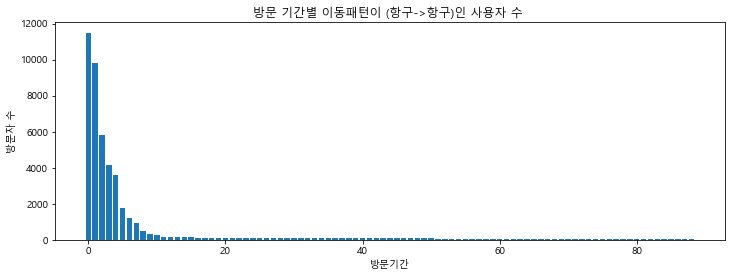

In [159]:
data = user_df[user_df['first_station'] == "airport"]
data = data[user_df['last_station'] == "airport"]
data = data["period"].value_counts()
data2 = data
print(data)
plt.rcParams["figure.figsize"] = (12,4)
plt.bar(range(len(data2)), data2)
plt.xlabel('방문기간')
plt.ylabel('방문자 수')
plt.title('방문 기간별 이동패턴이 (항구->항구)인 사용자 수 ')
plt.show()

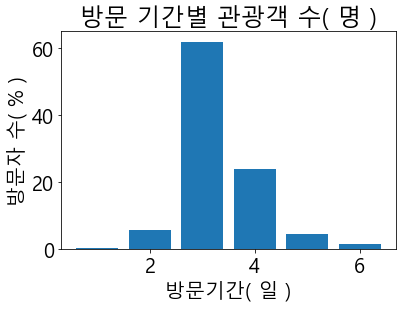

In [378]:
data2 = [0.3, 5.7, 61.8, 23.8, 4.5, 1.3]
plt.rcParams["figure.figsize"] = (6,4)
plt.bar(range(1, 7), data2)
plt.xlabel('방문기간( 일 )')
plt.ylabel('방문자 수( % )')
plt.title('방문 기간별 관광객 수( 명 )')
plt.show()

In [155]:
i=22
tourist = list(user_infor_df[user_infor_df["tourist"] == 1]["user_id"])
d = usage_df.query('{} == "{}"'.format("user_id", tourist[i]))[selete].sort_values(by = "geton_datetime")
end = d.tail(n=1).iloc[0, 4]
print(type(end))

<class 'float'>


In [32]:
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

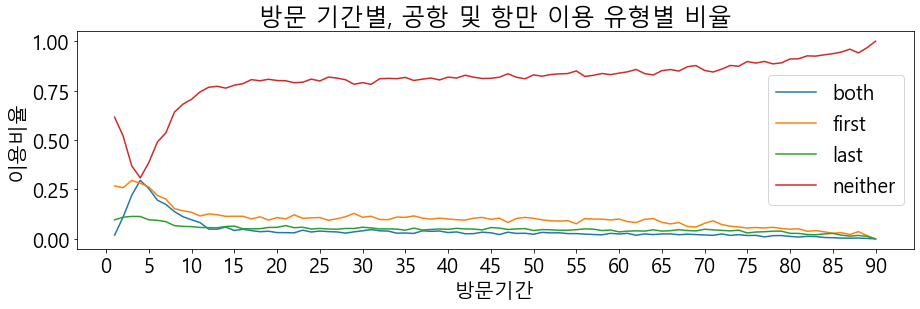

In [355]:
# 공항 이용율
wedgeprops={'width': 0.65, 'edgecolor': 'w', 'linewidth': 5}

columns = ['both', 'first', 'last', 'neither']
values = [[], [], [], []]
period = 90
term = 1
for period in list(range(1, period+1, term)):
    user_df2 = user_df[(period-1 < user_df['period']) & (user_df['period'] <= period)]
    for i in range(4):
        sum = len(user_df2)
        values[i].append(len(user_df2[user_df2[columns[i]]])/sum)

plt.rcParams["figure.figsize"] = (15,4)
for i in list(range(4)):
    plt.plot(list(range(1, period+1, term)), values[i])
    
plt.legend(columns)
plt.title('방문 기간별, 공항 및 항만 이용 유형별 비율')
plt.xlabel("방문기간")
plt.ylabel("이용비율")
plt.xticks(list(range(0, period+1, 5)))
plt.show()

해석
* 공항 또는 항만을 이용한 대중교통 승객은 2~10일 사이에 모여있다.
* both의 경우 관광객 방문기간 통계자료를 따른다.
* last의 경우 both와 first보다 상대적으로 낮은 비율을 보인다.
(보통 집에 공항으로 갈 땐 귀찮아서 택시를 이용하는 듯)

# 추출된 임의의 관광객 이동 패턴 출력 예시

In [30]:
def show_od_pattern(user_df, num):
    data = user_df[user_df["tourist"]]
    id = data.iloc[num, 0]
    select = ["base_date", "geton_datetime", "geton_stataion_name", "getoff_datetime", "getoff_station_name", "user_count"]
    od_df = usage_df.query('user_id == "{}"'.format(id)).sort_values('geton_datetime')
    return od_df[select]

In [197]:
data = user_df[user_df["tourist"]]
show_od_pattern(data, 7)

,base_date,geton_datetime,geton_stataion_name,getoff_datetime,getoff_station_name,user_count
32133,20190601,2019-06-01 12:09:29,"제주국제공항(대정,화순,일주서로)",2019-06-01 12:44:17,애월환승정류장(애월리),1
32132,20190601,2019-06-01 13:02:03,애월환승정류장(애월리),2019-06-01 13:04:19,한담동,1
32131,20190601,2019-06-01 16:19:50,곽지해수욕장,NaT,NaN,1
167881,20190602,2019-06-02 08:29:30,일성콘도미니엄,2019-06-02 08:37:52,신창중학교,1
167878,20190602,2019-06-02 08:54:59,구한경의원앞,NaT,NaN,1
167877,20190602,2019-06-02 12:00:02,법기동,2019-06-02 12:03:26,붉으내,1
167882,20190602,2019-06-02 14:40:22,고산1리(구출장소),2019-06-02 15:37:52,중문환승정류장(중문우체국),1
167880,20190602,2019-06-02 18:03:19,제주국제컨벤션센터중문대포해안주상절리대,2019-06-02 18:17:48,제주월드컵경기장(600번),1
167879,20190602,2019-06-02 18:28:59,서귀포시외버스터미널(가상정류소),2019-06-02 19:55:41,성산환승정류장(고성리회전교차로),1
249425,20190603,2019-06-03 11:58:53,세화환승정류장(세화리),2019-06-03 12:20:13,동복리,1
